# Homework: Multi-task Learning & Domain Adaptation
##  Named Entity Recognition

Today we're gonna solve the problem of named entity recognition. Here's what it does in one picture:
![img](https://commons.bmstu.wiki/images/0/00/NER1.png)
[image source](https://bit.ly/2Pmg7L2)


For each word, in a sentence, your model should predict a named entity class:


In [ ]:
import numpy as np
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

## Data

### Train set

Our model will train on a [Groningen Meaning Bank corpus](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus).

Each word of every sentence is labelled with named entity class and a part-of-speech tag.

### Source domain testset

Our train set consists from texts from different news sources. Therefore as source-domain testset we will use data from [CoNLL-2003 Shared Task](https://github.com/Franck-Dernoncourt/NeuroNER/blob/master/data/conll2003/en). More information about the task can be found [here](https://www.clips.uantwerpen.be/conll2003/ner/).

### Target domain (in-domain) data

As target-domain data we will use data from [WNUT17 Emerging and Rare entity recognition task](http://noisy-text.github.io/2017/emerging-rare-entities.html). This shared task focuses on identifying unusual, previously-unseen entities in the context of emerging discussions. The data were mined from mined from Twitter, Reddit,
YouTube and StackExchange. Results of different competitors of the task were published [here](https://noisy-text.github.io/2017/pdf/WNUT18.pdf).

### Named entity classes

* PER - _person_: names of people (e.g. Alexander S. Pushkin)
* ORG - _organization_: names of corporations (e.g. Yandex), names of non-profit organizations (e.g. UNICEF)
Google).
* LOC - _location_ : e.g. Russia
* MISC - _miscellaneous_ : other named entities including names of products (e.g. iPhone) and creative works (e.g. Bohemian Rhapsody)

### Evaluation metrics

As evaluation metrics we will F1 measure on exact matched NEs. It means that partially overlapped enitities of same class are considered as mismatch.
For example, LOC entities below is partially overlapped. And it is a mismatch:

__O, B-LOC, I-LOC, O__

__O, B-LOC, I-LOC, I-LOC__

Details can be found in the code of _conlleval.py_

### Data format

The format of all dataset follows popular [IOB format](https://en.wikipedia.org/wiki/Inside–outside–beginning_(tagging)). The B- prefix before a tag indicates that the tag is the beginning of a chunk, and an I- prefix before a tag indicates that the tag is inside a chunk. The B- tag is used only when a tag is followed by a tag of the same type without O tokens between them. An O tag indicates that a token belongs to no chunk.

The named entity labels include:
* __B-LOC__ - location - first token
* __I-LOC__ - location - subsequent tokens
* __B-ORG__ - organization - first token
* __O__ - not a named entity

Take a look for yourself:

In [ ]:
# Train:
!wget https://www.dropbox.com/s/xobyz6jgovvz3dm/kaggle-train.conll?dl=1 -O kaggle-train.conll

# Source domain testset:
!wget https://www.dropbox.com/s/1l8b9iy78cglrw3/source-domain-test.conll?dl=1 -O source-domain-test.conll

# Target domain testset:
!wget https://www.dropbox.com/s/oxfkdy23ux5hfz5/target-domain-test.conll?dl=1 -O target-domain-test.conll
    
# Target domain monolingual data:
!wget https://www.dropbox.com/s/ysdrotjdfljydbr/target-domain-monolingual.conll?dl=1 -O target-domain-monolingual.conll


In [3]:
from conlleval import evaluate
from utils import read_conll
data = read_conll('./kaggle-train.conll', lower_words=True)

data[333]

In [4]:
test_outdomain_data = read_conll('./source-domain-test.conll', lower_words=True)
test_indomain_data = read_conll('./target-domain-test.conll', column_names=['word', 'ne'], lower_words=True)
monolingual_indomain_data = read_conll('./target-domain-monolingual.conll', column_names=['word'], lower_words=True)

In [5]:
from sklearn.model_selection import train_test_split
train_data, dev_data = train_test_split(data, test_size=0.25, random_state=42)
print("train: {}, dev: {}".format(len(train_data), len(dev_data)))

train: 35967, dev: 11989


In [6]:
from utils import Vocab
vocabs = {
    key: Vocab.from_lines([row[key] for row in train_data])
    for key in ['word', 'pos', 'ne']
}

def prepare_batch(data):
    keys = data[0].keys()
    return {
        key: vocabs[key].to_matrix(row[key] for row in data)
        for key in keys
    }

In [7]:
dummy_rows = sorted(data, key=lambda row: len(row['word']))[100:102]
print(dummy_rows[0])
print(dummy_rows[1])
prepare_batch(dummy_rows)

{'word': 'well , it could happen !', 'pos': 'RB , PRP MD VB .', 'ne': 'O O O O O O'}
{'word': 'sudan denies the claim .', 'pos': 'NNP VBZ DT NN .', 'ne': 'B-LOC O O O O'}


{'ne': array([[10, 10, 10, 10, 10, 10],
        [ 2, 10, 10, 10, 10,  0]]), 'pos': array([[26,  4, 24, 17, 33,  5],
        [19, 38, 10, 18,  5,  0]]), 'word': array([[27512,   289, 13824,  7061, 12084,     2],
        [24626,  7884, 25433,  6090,   292,     0]])}

## Baseline: single-task model (1.5 points)

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/gorynich_ne.png)

Let's start with a straightforward model that does named entity recognition.


The image will make sense later :)

In [17]:
import keras, keras.layers as L

class SimpleModel:
    def __init__(self, name, emb_size=128, hid_size=128):
        """ 
        A model that predicts named entity class for each word
        We recommend the following model:
        * Embedding
        * Bi-directional LSTM
        * Linear layer to predict logits
        """
        
        # define layers
        self.emb = L.Embedding(len(vocabs['word']), emb_size)
        
        self.lstm = L.Bidirectional(L.CuDNNLSTM(hid_size, return_sequences=True))
        self.logits = L.Dense(len(vocabs['ne']))
    
    def __call__(self, input_ix):
        """
        Compute logits for named entity recognition
        :param input_ix: a matrix of token indices, int32[batch_size, seq_length]
        """
        ner_logits = self.logits(self.lstm(self.emb(input_ix)))
        return {'ne': ner_logits}


In [18]:
model = SimpleModel('mod1')



dummy_ix = tf.constant(prepare_batch(train_data[:3])['word'])
dummy_out = model(dummy_ix)

sess.run(tf.global_variables_initializer())
dummy_logits = sess.run(dummy_out['ne'])

assert dummy_logits.shape == (3, dummy_ix.shape[1], len(vocabs['ne']))
assert dummy_logits.min() < 0 and dummy_logits.max() > 0, "you ~may~ have added nonlinearity after logits."\
                                                          "Make sure they're just a linear layer"

In [19]:
from utils import infer_mask

class trainer:
    """ A bunch of tensorflow operations used for model training """
    
    ph = {
        'word': tf.placeholder('int32', [None, None], name='input_tokens'),
        'ne': tf.placeholder('int32', [None, None], name='named_entities'),
    }

    logits = model(ph['word'])
    mask = infer_mask(ph['word'])
    
    loss = -tf.nn.log_softmax(logits['ne'], -1) * tf.one_hot(ph['ne'], len(vocabs['ne']))
    loss = tf.reduce_sum(loss * mask[:, :, None]) / tf.reduce_sum(mask)

    step = tf.train.AdamOptimizer().minimize(loss)

### Training loop

Nothin' special: sample random batches and perform SGD steps

In [20]:
def iterate_minibatches(data, batch_size=128, shuffle=True, cycle=False, max_batches=None):
    indices = np.arange(len(data))
    total_batches = 0
    while True:
        if shuffle: indices = np.random.permutation(indices)
        for start_i in range(0, len(data), batch_size):
            batch_ix = indices[start_i: start_i + batch_size]
            yield prepare_batch(data[batch_ix])
            total_batches += 1
            if max_batches and total_batches >= max_batches:
                return
        if not cycle: break
            

def compute_error_rate(trainer, data, batch_size=128, key='ne'):
    numerator = denominator = 0.0
    for batch in iterate_minibatches(data, batch_size, shuffle=False, cycle=False):
        batch_ne_logits, batch_mask = sess.run([trainer.logits[key], trainer.mask], 
                                               {trainer.ph['word']: batch['word']})
        numerator += np.sum((batch[key] == batch_ne_logits.argmax(-1)) * batch_mask)
        denominator += batch_mask.sum()
    return (1.0 - numerator / denominator) * 100

def decode_greedy(trainer, data, vocabs, batch_size=128, key='ne'):
    result = []
    for batch in iterate_minibatches(data, batch_size, shuffle=False, cycle=False):
        batch_logits = sess.run(trainer.logits[key], 
                                {trainer.ph['word']: batch['word']})
        result.extend(vocabs[key].to_lines(batch_logits.argmax(-1)))
    return result

def compute_stats(trainer, data, vocabs, batch_size=128, key='ne', verbose=False):
    pred_seqs = decode_greedy(trainer, data, vocabs, batch_size, key)
    true_seqs = [r[key] for r in data]
    precision, recall, f1 = evaluate(true_seqs, pred_seqs, verbose)
    return precision, recall, f1
    

In [21]:
class StatsHistory:
    def __init__(self):
        self.precision = []
        self.recall = []
        self.f1 = []

In [22]:
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
eval_every = 100

loss_history = []
dev_stats_history = StatsHistory()
indomain_stats_history = StatsHistory()
outdomain_stats_history = StatsHistory()

sess.run(tf.global_variables_initializer())

In [23]:
len(dev_data)

11989

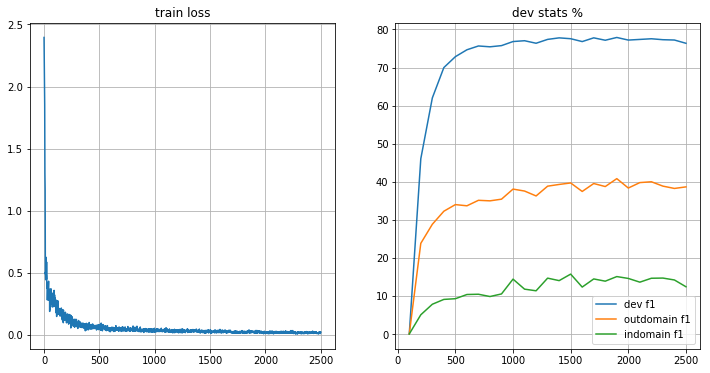

2500it [01:56, 21.41it/s]


In [24]:
for batch in tqdm(iterate_minibatches(train_data, cycle=True, max_batches=2500), total=2500):
    loss_t, _ = sess.run([trainer.loss, trainer.step],
                         {trainer.ph[key]: batch[key] for key in trainer.ph})
    loss_history.append(loss_t)
    
    if len(loss_history) % eval_every == 0:
        precision, recall, f1 = compute_stats(trainer, dev_data, vocabs, verbose=True)
        dev_stats_history.precision.append(precision)
        dev_stats_history.recall.append(recall)
        dev_stats_history.f1.append(f1)
        
        clear_output(True)
        
        _, _, f1 = compute_stats(trainer, test_outdomain_data, vocabs, verbose=True)
        outdomain_stats_history.f1.append(f1)
        
        _, _, f1 = compute_stats(trainer, test_indomain_data, vocabs, verbose=True)
        indomain_stats_history.f1.append(f1)

        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('train loss'), plt.grid()
        plt.subplot(1, 2, 2)
        
        plt.plot(np.arange(1, len(dev_stats_history.f1) + 1) * eval_every, dev_stats_history.f1, label="dev f1")
        plt.plot(np.arange(1, len(outdomain_stats_history.f1) + 1) * eval_every, outdomain_stats_history.f1, label="outdomain f1")
        plt.plot(np.arange(1, len(indomain_stats_history.f1) + 1) * eval_every, indomain_stats_history.f1, label="indomain f1")

        plt.legend()
        plt.title('dev stats %'), plt.grid()
        plt.show()

In [25]:
print("Best dev f1 = %.3f%%" % max(dev_stats_history.f1),
      "\nBest in-domain f1 = %.3f%%" % max(indomain_stats_history.f1),
      "\nBest out-of-domain f1 = %.3f%%" % max(outdomain_stats_history.f1))
assert max(dev_stats_history.f1) > 75, "you can do better"

Best dev f1 = 77.892% 
Best in-domain f1 = 15.725% 
Best out-of-domain f1 = 40.806%


# Multitask model: NER + POS (1.5 points)

Our data contains not only named entity labels, but also part-of-speech tags. Those problems are similar in nature, making it a good candidate for multi-tasking. With any luck, ouyr model will become better at named entity recognition by learning for POS-tagging.

![model2](https://github.com/yandexdataschool/nlp_course/raw/master/resources/gorynich_2.png)

In [28]:
import keras, keras.layers as L

class MultitaskModel:
    def __init__(self, name, emb_size=128, hid_size=128):
        """ 
        Equivalent to the SimpleModel above, but with two 
        linear "heads": one for "ne" logits and another for "pos".
        Both heads should grow from the same intermediate "body" layer
        """
        self.emb = L.Embedding(len(vocabs['word']), emb_size)
        
        self.lstm = L.Bidirectional(L.CuDNNLSTM(hid_size, return_sequences=True))
        self.logits_ner = L.Dense(len(vocabs['ne']))
        self.logits_pos = L.Dense(len(vocabs['pos']))

    
    def __call__(self, input_ix):
        """
        Compute logits for named entity recognition
        """
        intermediate = self.lstm(self.emb(input_ix))
        ner_logits = self.logits_ner(intermediate)
        pos_logits = self.logits_pos(intermediate)
        return {'ne': ner_logits, 'pos': pos_logits}

In [29]:
model = MultitaskModel('mod2')

dummy_ix = tf.constant(prepare_batch(train_data[:3])['word'])
dummy_out = model(dummy_ix)
assert 'ne' in dummy_out and 'pos' in dummy_out

sess.run(tf.global_variables_initializer())

for key, logits in sess.run(dummy_out).items():
    assert logits.shape == (3, dummy_ix.shape[1], len(vocabs[key]))

In [31]:
from utils import infer_mask

class multitask_trainer:
    """ A trainer that computes losses for both NER and POS tasks and adds them together. """    
    ph = {
        'word': tf.placeholder('int32', [None, None], name='input_tokens'),
        'ne': tf.placeholder('int32', [None, None], name='named_entities'),
        'pos': tf.placeholder('int32', [None, None], name='part_of_speech_tags'),
    }

    logits = model(ph['word'])
    mask = infer_mask(ph['word'])
    
    # Compute loss for NER. Feel free to reuse the code from original trainer
    ner_loss = -tf.nn.log_softmax(logits['ne'], -1) * tf.one_hot(ph['ne'], len(vocabs['ne']))
    ner_loss = tf.reduce_sum(ner_loss * mask[:, :, None]) / tf.reduce_sum(mask)

    # Compute the same kind of loss for POS.  (key: 'pos')
    pos_loss = -tf.nn.log_softmax(logits['pos'], -1) * tf.one_hot(ph['pos'], len(vocabs['pos']))
    pos_loss = tf.reduce_sum(pos_loss * mask[:, :, None]) / tf.reduce_sum(mask)
    
    # The total loss is just a sum of two losses.
    # Note: you can use weighted combination of losses to squeeze a few more %%
    loss = ner_loss + pos_loss
    step = tf.train.AdamOptimizer().minimize(loss)

In [32]:
dummy_batch = prepare_batch(train_data[:3])
ner_loss, pos_loss = sess.run([multitask_trainer.ner_loss, multitask_trainer.pos_loss], 
                              {multitask_trainer.ph[key]: dummy_batch[key] for key in multitask_trainer.ph})

assert ner_loss > 0 and np.shape(ner_loss) == (), "loss must be a positive scalar"
assert pos_loss > 0 and np.shape(pos_loss) == (), "loss must be a positive scalar"

In [33]:
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

loss_history = []
dev_stats_history = StatsHistory()
indomain_stats_history = StatsHistory()
outdomain_stats_history = StatsHistory()

sess.run(tf.global_variables_initializer())

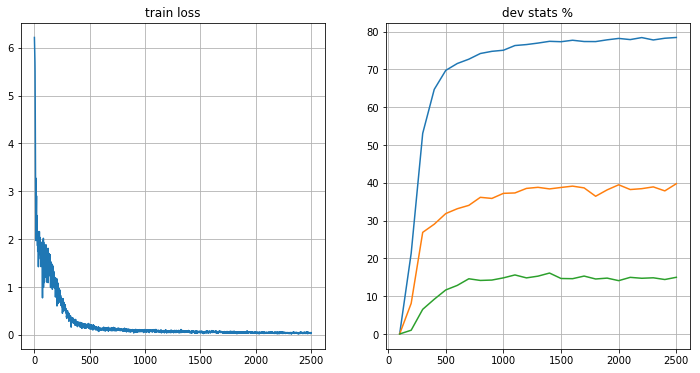

2500it [01:54, 21.85it/s]


In [34]:
for batch in tqdm(iterate_minibatches(train_data, cycle=True, max_batches=2500), total=2500):
    loss_t, _ = sess.run([multitask_trainer.loss, multitask_trainer.step], 
                         {multitask_trainer.ph[key]: batch[key] for key in multitask_trainer.ph})
    loss_history.append(loss_t)
    
    if len(loss_history) % 100 == 0:
        precision, recall, f1 = compute_stats(multitask_trainer, dev_data, vocabs, verbose=True)
        dev_stats_history.precision.append(precision)
        dev_stats_history.recall.append(recall)
        dev_stats_history.f1.append(f1)
        
        clear_output(True)
        
        _, _, f1 = compute_stats(multitask_trainer, test_outdomain_data, vocabs, verbose=True)
        outdomain_stats_history.f1.append(f1)
        
        _, _, f1 = compute_stats(multitask_trainer, test_indomain_data, vocabs, verbose=True)
        indomain_stats_history.f1.append(f1)
        
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('train loss'), plt.grid()
        plt.subplot(1, 2, 2)
        
        plt.plot(np.arange(1, len(dev_stats_history.f1) + 1) * eval_every, dev_stats_history.f1, label="dev f1")
        plt.plot(np.arange(1, len(outdomain_stats_history.f1) + 1) * eval_every, outdomain_stats_history.f1, label="outdomain f1")
        plt.plot(np.arange(1, len(indomain_stats_history.f1) + 1) * eval_every, indomain_stats_history.f1, label="indomain f1")
        
        plt.title('dev stats %'), plt.grid()
        plt.show()

In [35]:
print("Best dev f1 = %.3f%%" % max(dev_stats_history.f1),
      "\nBest indomain f1 = %.3f%%" % max(indomain_stats_history.f1),
      "\nBest outdomain f1 = %.3f%%" % max(outdomain_stats_history.f1))
assert max(dev_stats_history.f1) > 75, "you can do better"

Best dev f1 = 78.462% 
Best indomain f1 = 16.123% 
Best outdomain f1 = 39.764%


# Multitask model: NER + POS + LM (2 points)

Two heads are great, but three's even better! Let's add language modeling to the task.

With language models, however, there are a few complications:
* Our data is too small for LM training. Let's use [1 billion word benchmark](http://www.statmt.org/lm-benchmark/) instead. It *may* even be a good idea to preserve cases.
* Language models have some issues with being bidirectional. We recommend training forward and backward models separately and fusing them together. Or use the same approach as [ELMO](https://tfhub.dev/google/elmo/2).
* The simplest scheme is to pre-train as a language model and fine-tune for NER and POS. We recommend starting from that.

__IMPORTANT!__ NER/POS dataset comes pre-tokenized.  Make sure you apply {almost} the same tokenization when training language model. Alternatively, you can re-tokenize ner/pos data.


![model3](https://github.com/yandexdataschool/nlp_course/raw/master/resources/gorynich_small.png)

In [ ]:
class MultitaskModel:
    def __init__(self, name, emb_size=128, hid_size=128):
        """ 
        Equivalent to the SimpleModel above, but with three
        linear "heads": one for "ne" logits, second for "pos" and last for language modelling.
        Both heads should grow from the same intermediate "body" layer
        """
        # define layers:
        <YOUR CODE>

    def __call__(self, input_ix):
        """
        Compute logits for named entity recognition
        """
        <YOUR CODE>

        ner_logits = #<YOUR_CODE>
        pos_logits = #<YOUR_CODE>
        lm_logits = #<YOUR_CODE>
        return {'ne': ner_logits, 'pos': pos_logits, 'lm': lm_logits}

In [ ]:
model = MultitaskModel('mod3')

dummy_ix = tf.constant(prepare_batch(train_data[:3])['word'])
dummy_out = model(dummy_ix)
assert 'ne' in dummy_out and 'pos' in dummy_out and 'lm' in dummy_out

sess.run(tf.global_variables_initializer())

Different schemes for multitask learning with Language Model component.

You can try at least two of them:
* Pretrain network using monolingual data as Language Model and then train model as NER and POS tagger.
* Train network alternately: one step on NER and POS tasks, one step on LM tasks. 


In [ ]:
from utils import infer_mask



class multitask_trainer:
    """ A trainer that computes losses for both NER, POS and LM tasks and adds them together. """
    ph = {
        'word': tf.placeholder('int32', [None, None], name='input_tokens'),
        'ne': tf.placeholder('int32', [None, None], name='named_entities'),
        'pos': tf.placeholder('int32', [None, None], name='part_of_speech_tags'),
        'lm': tf.placeholder('int32', [None, None], name='output_tokens'),
    }

    logits = model(ph['word'])
    mask = infer_mask(ph['word'])

    # Compute loss for NER. Feel free to reuse the code from original trainer

    ner_loss = <YOUR_CODE>

    # Compute the same kind of loss for POS.  (key: 'pos')

    pos_loss = <YOUR CODE>

    # Compute the same kind of loss for LM.

    lm_loss = <YOUR CODE>

    # YOUR CODE HERE


In [ ]:
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

loss_history = []
dev_stats_history = StatsHistory()
indomain_stats_history = StatsHistory()
outdomain_stats_history = StatsHistory()

sess.run(tf.global_variables_initializer())

In [ ]:
for batch in tqdm(iterate_minibatches(train_data, cycle=True, max_batches=2500), total=2500):
    # YOUR CODE HERE
    loss_history.append(loss_t)
    
    if len(loss_history) % 100 == 0:
        # YOUR CODE HERE
        
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('train loss'), plt.grid()
        plt.subplot(1, 2, 2)
        
        plt.plot(np.arange(1, len(dev_stats_history.f1) + 1) * eval_every, dev_stats_history.f1, label="dev f1")
        plt.plot(np.arange(1, len(outdomain_stats_history.f1) + 1) * eval_every, outdomain_stats_history.f1, label="outdomain f1")
        plt.plot(np.arange(1, len(indomain_stats_history.f1) + 1) * eval_every, indomain_stats_history.f1, label="indomain f1")
        
        plt.title('dev stats %'), plt.grid()
        plt.show()

# Structured prediction for NEs (2 points)

![lstm_crf_ner](https://github.com/yandexdataschool/nlp_course/raw/master/resources/lstm_crf_ner.png)

[_Picture from  Lample et al._](https://arxiv.org/abs/1603.01360)

A setup with seq2seq and cross-entropy loss for tagging is not so good. Because in the case tagging there is an important constraint: input and output sequence have same length, and the number of output token types is much less than the number of input token types.

To use this constraint effectively it is good idea to try structured [CRF loss](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/crf) for NER (and POS)


A good example of TensorFlow implementation of NER NN with CRF loss can be found in the [blogpost](https://guillaumegenthial.github.io/sequence-tagging-with-tensorflow.html)

## Dealing with letter case and rare entities (1 points)

![lstm_crf_ner](https://github.com/yandexdataschool/nlp_course/raw/master/resources/word_and_char_embedding_concat.png)

[_Picture from  Lample et al._](https://arxiv.org/abs/1603.01360)

First, in European languages (both English and Russian) personal names, companies, geographical names are capitalized traditionally. Thus the letter case carries a powerful signal for named entities recognition. So it is good to utilize it.

Second, most of named entities are rare words. In testsets (both from source and target distributions) they are replaced by _UNK_. To deal with OOV words you can try different approaches (feel free!). For example:

* You can use additional character-level recurrent layers to obtain character-aware word embeddings (see scheme on the picture above)
* You can use pretrained embeddings with character ngram information ([FastText](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md))
* You can split words by subword units using [BPE](https://arxiv.org/abs/1508.07909)

## Domain adaptation via proxy-labels (2 points)

As you can see above the quality of NER on the target domain (internet comments) is much worse than on the source domain (news). This is not surprising.

To overcome the problem we offer you to implement any kind of proxy-label method. A good overview on this kind of methods can be found [here](https://arxiv.org/abs/1804.09530)

__ATTENTION!!!__ For proxy-labeling use monolingual target-domain dataset (not testset!).

Good luck!